<a href="https://colab.research.google.com/github/poomkusa/Artificial-Intelligence-and-the-Future-of-Marketing-Education-Special-Issue/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP sentiment analysis and topic modeling

In this notebook we will take alook at text data. We will do:

    1) Topic Modeling
    2) Sentiment Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
#from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [4]:
from google.colab import files
uploaded = files.upload()

Saving tweets_v172_sample.csv to tweets_v172_sample.csv


In [7]:
# load data

import io
data = pd.read_csv(io.BytesIO(uploaded['tweets_v172_sample.csv']))

In [8]:
data.head()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,reigndomains 👑,https://t.co/6tFaOonLtv 🔥 for sale .\n\n#Royal...,NaN,Brand Name | https://t.co/Z4d6GWXyWz | https:/...,2019-09-11 04:04:06+00:00,267,256,1300,False,2023-06-10 12:37:16+00:00,"['RoyalGPT', 'Royal', 'Domains', 'ai', 'Web3',...",Twitter for iPhone
1,MidJourney LIVE,Exquisite realism photography showcasing an ex...,Follow for Inspiration,🎨 Live feed of Art generated by Midjourney AI 🎨,2018-08-28 02:01:04+00:00,100,1,0,False,2023-06-10 12:36:56+00:00,NaN,MidjourneyLIVE
2,The Tech Trend,Top 10 ChatGPT Plugins You Should Use Right No...,Worldwide,"A Tech community for industry experts, connect...",2020-09-15 15:37:37+00:00,4380,4668,242,False,2023-06-10 12:35:00+00:00,"['ChatGPT', 'bestChatGPTplugins']",Buffer
3,The Time Blawg,What lawyers will get out of ChatGPT: legal ca...,Scotland... and Beyond,"The past, present and future practice of law (...",2010-12-29 18:03:14+00:00,5897,6499,4693,False,2023-06-10 12:34:49+00:00,NaN,Twitter for Android
4,Christine Lopez,down an a But the state of summer8 being money...,NaN,NaN,2023-05-06 11:03:29+00:00,0,5,0,False,2023-06-10 12:33:14+00:00,"['车震', '嫩穴', 'chatGPT']",Twitter Web App


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         1000 non-null   object
 1   text              1000 non-null   object
 2   user_location     696 non-null    object
 3   user_description  943 non-null    object
 4   user_created      1000 non-null   object
 5   user_followers    1000 non-null   int64 
 6   user_friends      1000 non-null   int64 
 7   user_favourites   1000 non-null   int64 
 8   user_verified     1000 non-null   bool  
 9   date              1000 non-null   object
 10  hashtags          637 non-null    object
 11  source            1000 non-null   object
dtypes: bool(1), int64(3), object(8)
memory usage: 87.0+ KB


In [14]:
(data.isnull().sum() / len(data)) * 100

user_name            0.0
text                 0.0
user_location       30.4
user_description     5.7
user_created         0.0
user_followers       0.0
user_friends         0.0
user_favourites      0.0
user_verified        0.0
date                 0.0
hashtags            36.3
source               0.0
dtype: float64

<font color='red'>We see some columns having too many missing values. We will drop those.</font>

In [ ]:
# del data['id']
# del data['author_flair_text']
# del data['removed_by']
# del data['total_awards_received']
# del data['awarders']
# del data['created_utc']
# del data['full_link']

In [ ]:
# Drop the columns where at least one element is missing
data = data.dropna()

In [ ]:
data.head()

In [ ]:
data.info()

Now we have only the relevant information and no missing values.

In [15]:
# check out numeric columns

data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_followers,1000.0,42366.551,513728.637028,0.0,20.0,174.0,1045.25,8702209.0
user_friends,1000.0,2757.657,11874.414246,0.0,21.0,164.0,866.00,122047.0
user_favourites,1000.0,9235.729,37883.991512,0.0,14.0,363.5,2752.75,400441.0


Both columns look like they are heavily skewed when comparing the 75 percentile and max values.

In [16]:
len(data)

1000

### The distribution is heavily skewed

<ipython-input-18-fa280d4ad6c5>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['user_followers'], shade=  True)


<Axes: xlabel='user_followers', ylabel='Density'>

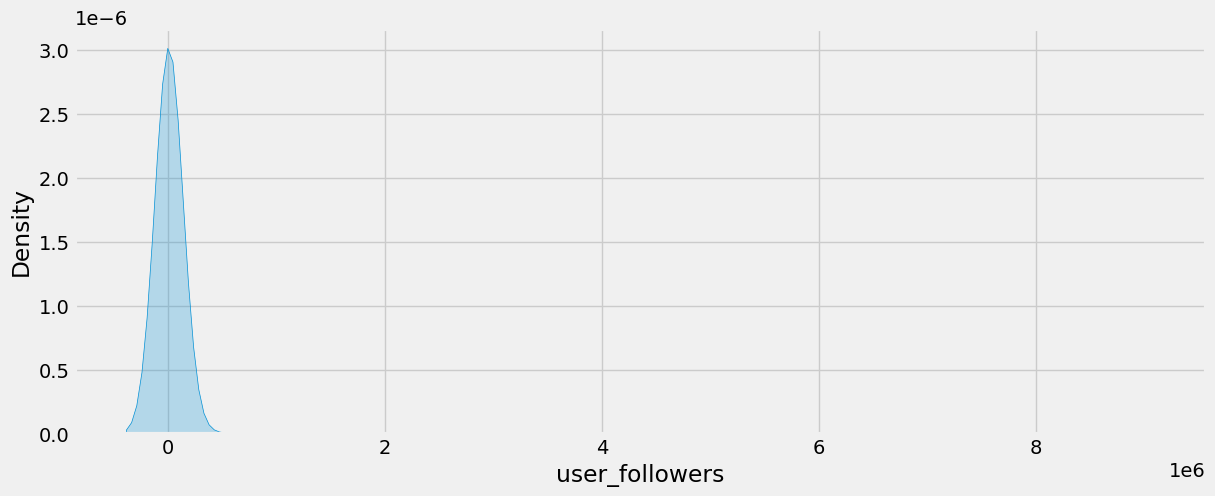

In [18]:
plt.figure(figsize=(13,5))

sns.kdeplot(data['user_followers'], shade=  True)

In [23]:
print(len(data[data['user_followers'] < 1000]), 'users with less than 1000 followers')
print(len(data[data['user_followers'] > 1000]), 'users with more than 1000 followers')

740 users with less than 10 followers
260 users with more than 10 followers


In [25]:
# User with the most followers

data[data['user_followers'] == data['user_followers'].max()]['user_name'].iloc[0]

'Hindustan Times'

In [27]:
hin = df[(df['user_name']=="Hindustan Times")].reset_index(drop=True)
hin.head()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Hindustan Times,An experimental Lutheran church service was al...,India,One of India's largest media companies. Latest...,2009-04-29 10:11:34+00:00,8702209,129,2896,False,2023-06-10 11:41:07+00:00,"['AI', 'ChatGPT', 'ArtificialIntelligence']",Twitter Web App
1,Hindustan Times,"#OpenAI CEO #SamAltman, during his visit to #I...",India,One of India's largest media companies. Latest...,2009-04-29 10:11:34+00:00,8702209,129,2896,False,2023-06-10 05:51:23+00:00,"['OpenAI', 'SamAltman', 'India']",TweetDeck
2,Hindustan Times,#US lawyer used #ChatGPT to prepare court fili...,India,One of India's largest media companies. Latest...,2009-04-29 10:11:34+00:00,8702209,129,2896,False,2023-06-10 05:32:20+00:00,"['US', 'ChatGPT']",Twitter Web App


## Cleaning

These are useful cleaning functions

In [28]:


def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]
    return ' '.join(text_high_use)

#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text
#%%



Now using list comprehension we clean the titles and append the cleaned text as columns to the df.

In [ ]:
#https://stackoverflow.com/questions/55557004/getting-attributeerror-float-object-has-no-attribute-replace-error-while
#To avoid with tqdm AttributeError: 'float' object has no attribute

df["text"] = df["text"].astype(str)
df["text"] = [x.replace(':',' ') for x in df["text"]]

In [31]:
nltk.download('punkt')
nltk.download('stopwords')
data['clean_text'] = pd.Series([clean_text(i) for i in tqdm(data['text'])])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/1000 [00:00<?, ?it/s]

### Wordcloud

In [38]:
words = data["clean_text"].values

In [40]:
ls = []

for i in words:
    ls.append(str(i))

In [41]:
ls[:5]

['https tcotfaoonltv sale royalgpt royal domain ai web gpt chatgpt domainnameforsal cryptonew blockchain agi crypto defi nft cryptotrad nftart webnam',
 'exquisit realism photographi showcas extrem handsom gay coupl various shot scene artificialintellig ai nft nftart machinelearn chatgpt art tech deeplearn technolog digitalart tiktok https tcolzmrzvsn',
 'top  chatgpt plugin use right read https tcopjvcgsrwk chatgpt bestchatgptplugin aichatbot topchatgptplugin thetechtrend',
 'lawyer get chatgpt legal case pursu behalf client openai su defam chatgpt fabric legal accus radio host https tcopkhetdxsef legaltech lawyer ai chatgpt openai hallucin',
 'state summer money chatgpt https tcottsmleb']

(-0.5, 1599.5, 799.5, -0.5)

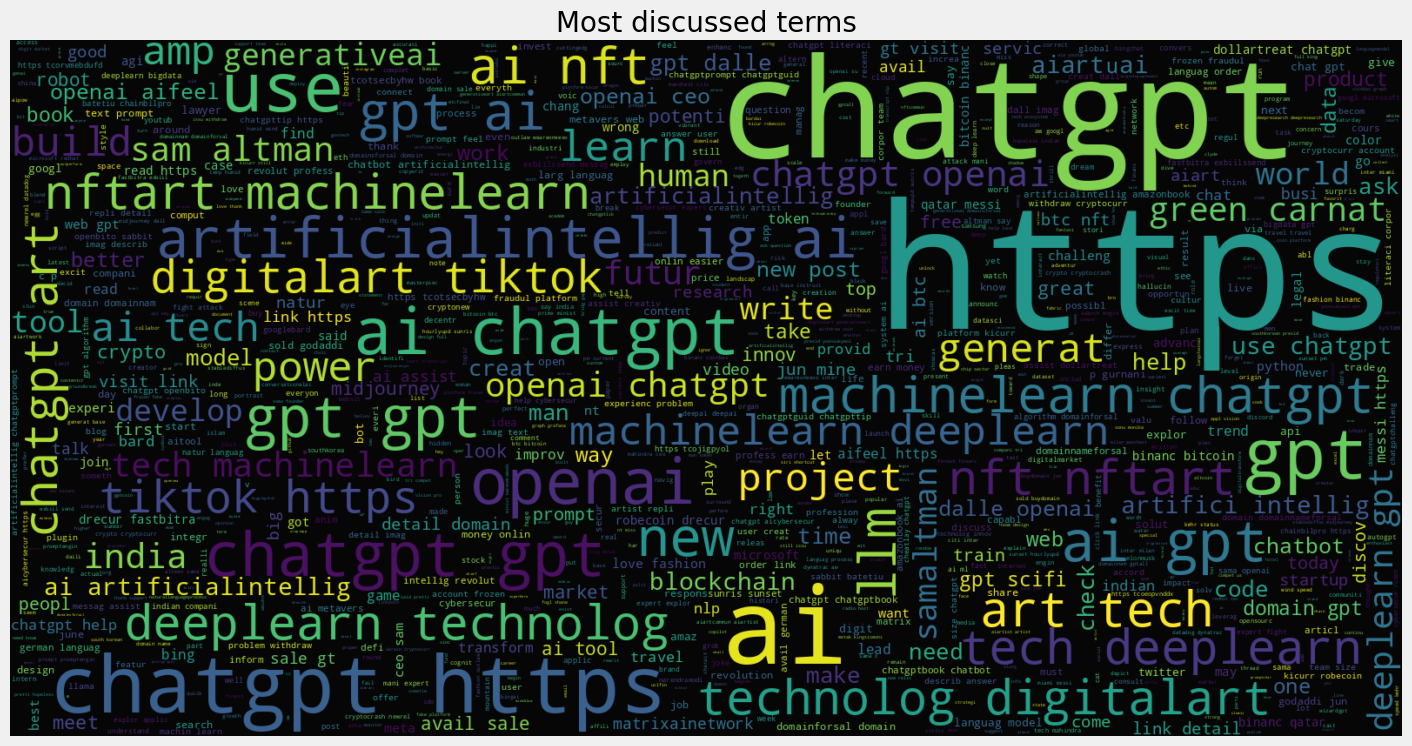

In [43]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

### Most popular posts

In [44]:
most_pop = df.sort_values('user_followers', ascending =False)[['user_name', 'user_followers']].head(12)

most_pop['user_followers1'] = most_pop['user_followers']/1000

<ipython-input-44-d7db00e03894>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_pop['user_followers1'] = most_pop['user_followers']/1000


Text(0.5, 1.0, 'Followers')

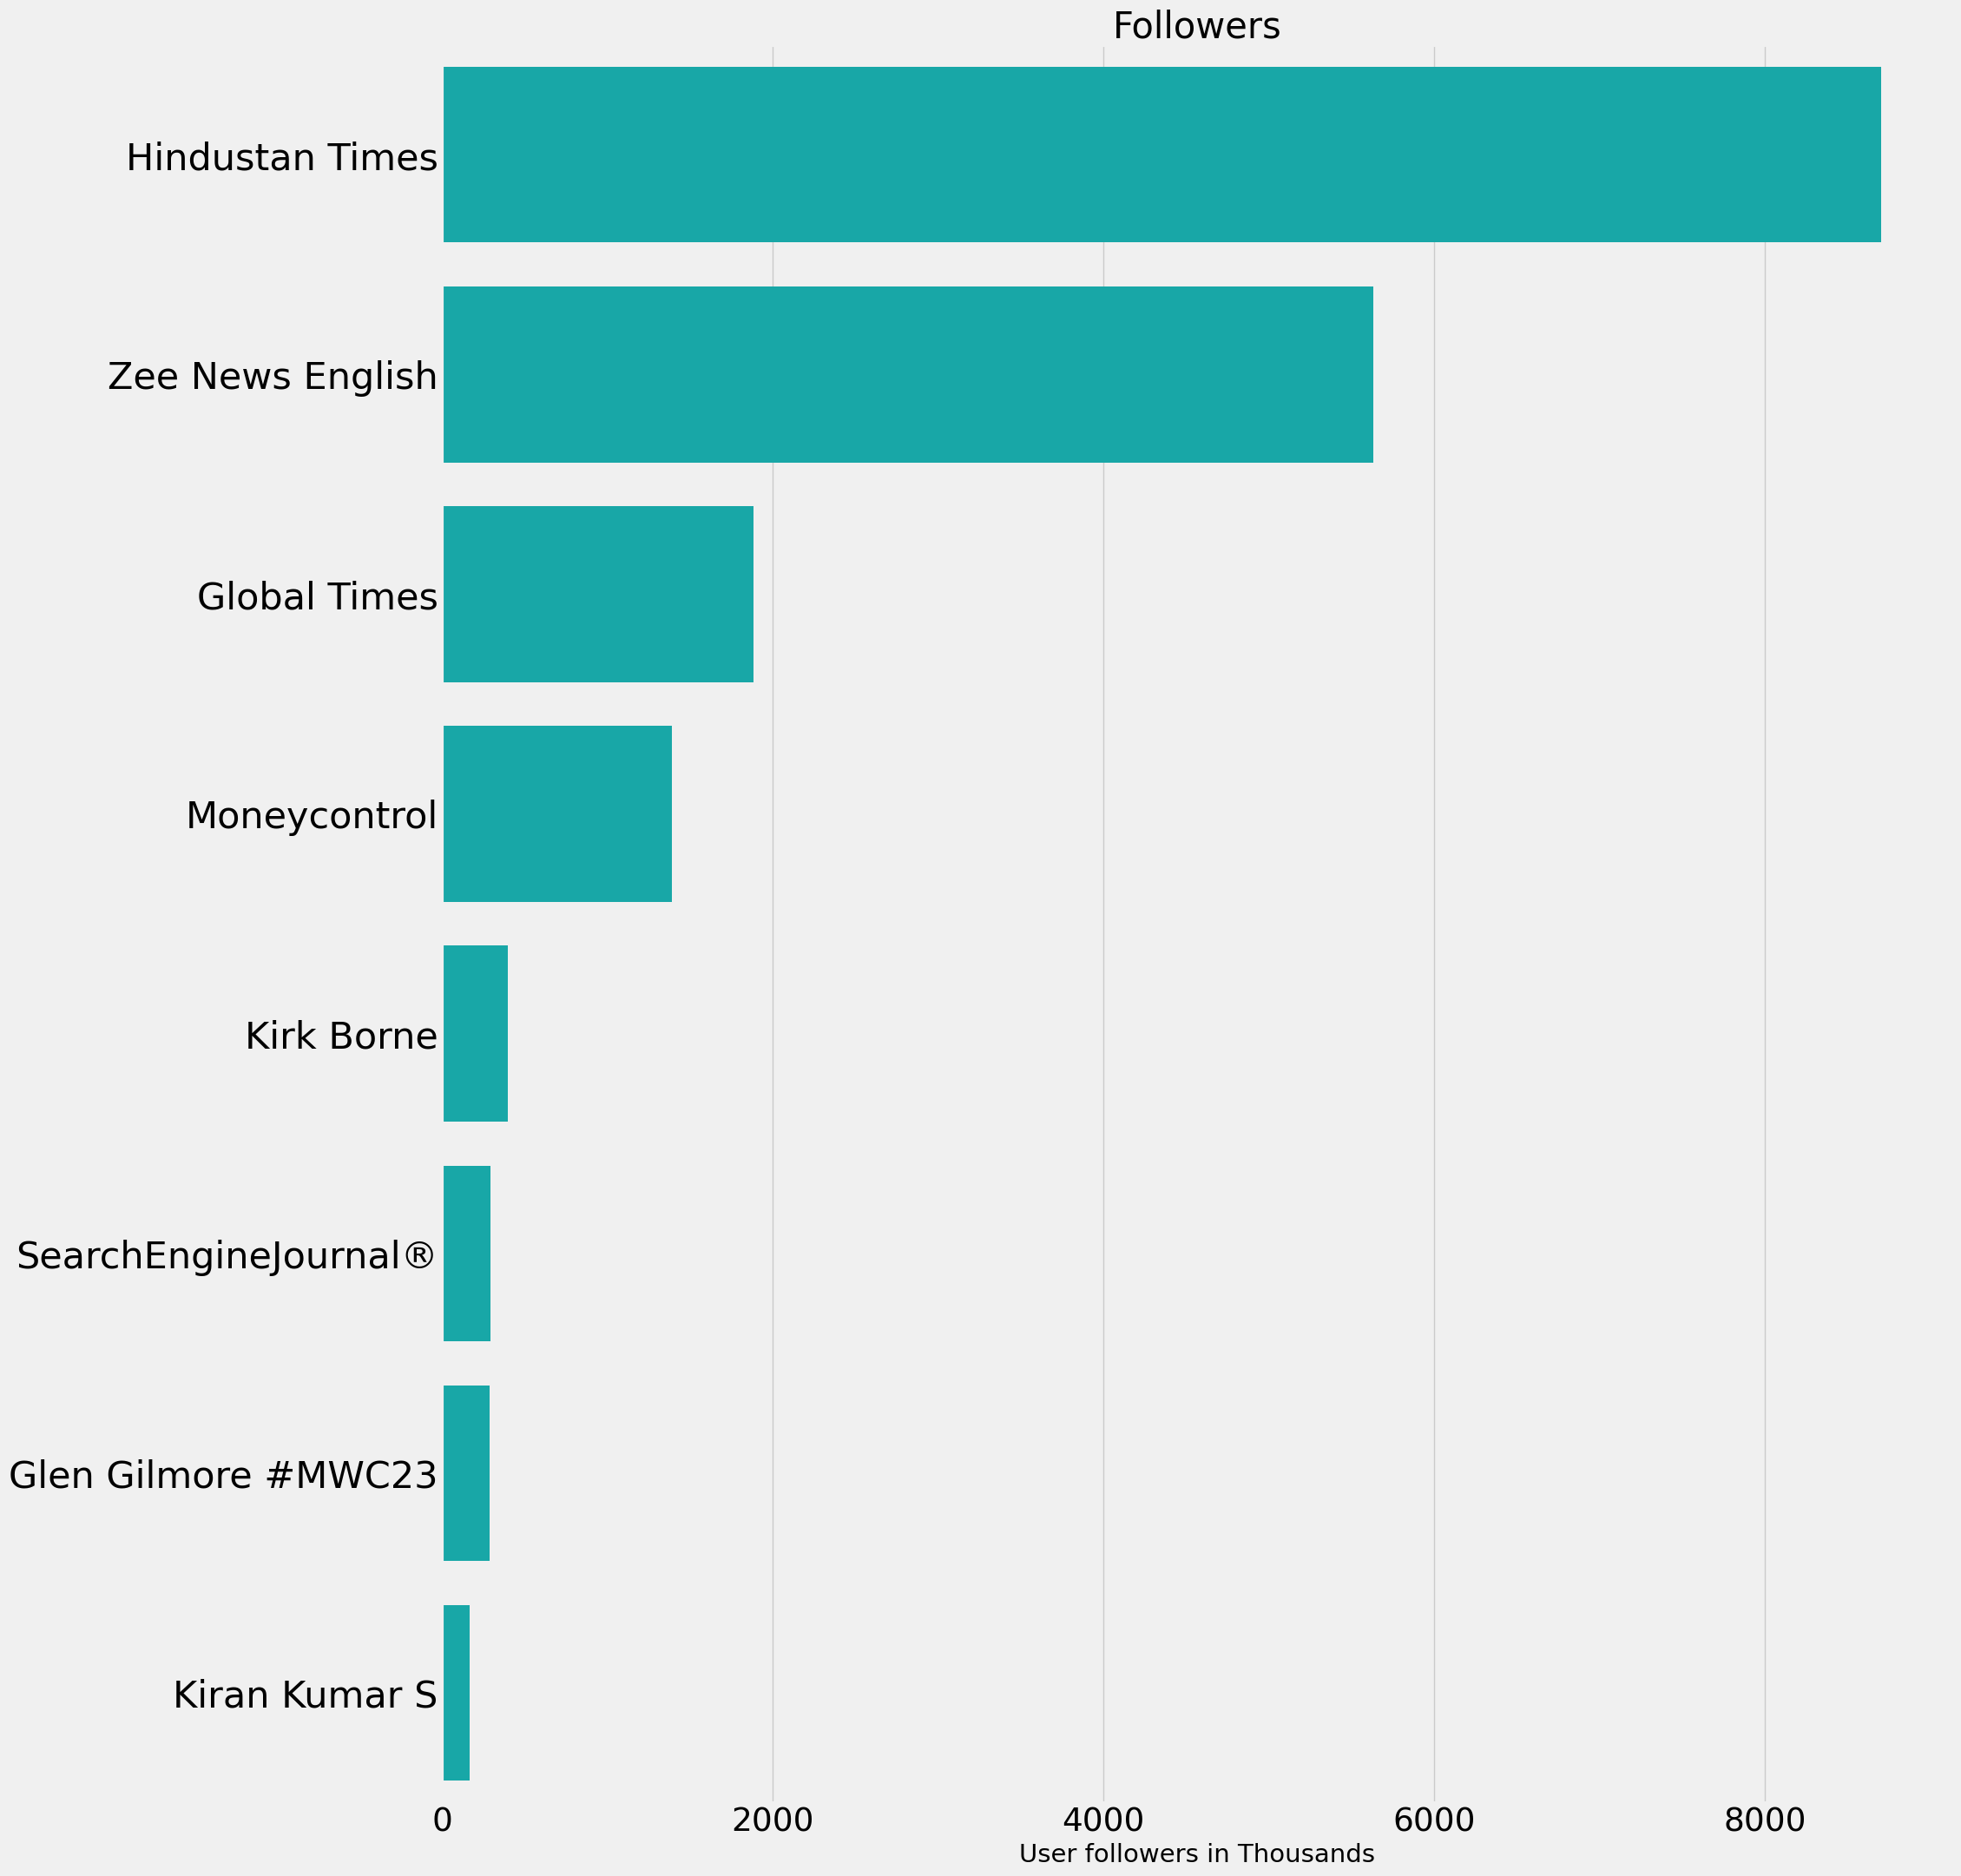

In [49]:
plt.figure(figsize = (20,25))

sns.barplot(data = most_pop, y = 'user_name', x = 'user_followers1', color = 'c')
plt.xticks(fontsize=27, rotation=0)
plt.yticks(fontsize=31, rotation=0)
plt.xlabel('User followers in Thousands', fontsize = 21)
plt.ylabel('')
plt.title('Followers', fontsize = 30)

In [50]:
data.head()

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,clean_text
0,reigndomains 👑,https://t.co/6tFaOonLtv 🔥 for sale .\n\n#Royal...,NaN,Brand Name | https://t.co/Z4d6GWXyWz | https:/...,2019-09-11 04:04:06+00:00,267,256,1300,False,2023-06-10 12:37:16+00:00,"['RoyalGPT', 'Royal', 'Domains', 'ai', 'Web3',...",Twitter for iPhone,https tcotfaoonltv sale royalgpt royal domain ...
1,MidJourney LIVE,Exquisite realism photography showcasing an ex...,Follow for Inspiration,🎨 Live feed of Art generated by Midjourney AI 🎨,2018-08-28 02:01:04+00:00,100,1,0,False,2023-06-10 12:36:56+00:00,NaN,MidjourneyLIVE,exquisit realism photographi showcas extrem ha...
2,The Tech Trend,Top 10 ChatGPT Plugins You Should Use Right No...,Worldwide,"A Tech community for industry experts, connect...",2020-09-15 15:37:37+00:00,4380,4668,242,False,2023-06-10 12:35:00+00:00,"['ChatGPT', 'bestChatGPTplugins']",Buffer,top chatgpt plugin use right read https tcopj...
3,The Time Blawg,What lawyers will get out of ChatGPT: legal ca...,Scotland... and Beyond,"The past, present and future practice of law (...",2010-12-29 18:03:14+00:00,5897,6499,4693,False,2023-06-10 12:34:49+00:00,NaN,Twitter for Android,lawyer get chatgpt legal case pursu behalf cli...
4,Christine Lopez,down an a But the state of summer8 being money...,NaN,NaN,2023-05-06 11:03:29+00:00,0,5,0,False,2023-06-10 12:33:14+00:00,"['车震', '嫩穴', 'chatGPT']",Twitter Web App,state summer money chatgpt https tcottsmleb


In [ ]:
most_com = data.sort_values('num_comments', ascending =False)[['title', 'num_comments', 'author']].head(12)
most_com['num_comments1'] = most_com['num_comments']/1000

In [ ]:
type(most_com)

In [ ]:
x = data.reset_index()
x[x['index'] == 92800]

In [ ]:
most_com = most_com[most_com.author != 'dinoignacio']

In [ ]:
plt.figure(figsize = (20,25))

sns.barplot(data = most_com, y = 'title', x = 'num_comments1', color = 'y')
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=30, rotation=0)
plt.xlabel('Comments in Thousands', fontsize = 21)
plt.ylabel('')
plt.title('Most commented posts', fontsize = 30)

The titles with the most cpmments seem to be more controversial, which makes sense.

In [ ]:
most_com.head(10)

In [ ]:
n = data.sort_values('score', ascending =False)

n['score1'] = n['score']/1000
n['num_comments1'] = n['num_comments']/1000

In [ ]:
plt.figure(figsize = (15,15))

sns.regplot(data = n, y = 'score1', x = 'num_comments1', color = 'purple')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Comments in Thousands', fontsize = 15)
plt.ylabel('Votes in Thousands')
plt.title('Comments and votes', fontsize = 14)

In [ ]:
data[data['num_comments'] == data['num_comments'].max()]

# Natural Language Processing

## Topic Modeling

In [51]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


In [52]:
stemmer = SnowballStemmer('english')

In [53]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [54]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [58]:
data['text'].iloc[1]

'Exquisite realism photography showcasing an extremely handsome gay couple in various shots and scenes. \n\n𝙁𝙤𝙡𝙡𝙤𝙬 𝙛𝙤𝙧 𝙈𝙤𝙧𝙚! \n\n#artificialintelligence #ai #nft #nftart #machinelearning #chatgpt #art #tech #deeplearning #technology #digitalart #tiktok https://t.co/5LZ0MrZvSN'

In [62]:
doc_sample = data['text'].iloc[1]
print('original document: ')

words = []

for word in doc_sample.split(' '):
    words.append(word)


print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Exquisite', 'realism', 'photography', 'showcasing', 'an', 'extremely', 'handsome', 'gay', 'couple', 'in', 'various', 'shots', 'and', 'scenes.', '\n\n𝙁𝙤𝙡𝙡𝙤𝙬', '𝙛𝙤𝙧', '𝙈𝙤𝙧𝙚!', '\n\n#artificialintelligence', '#ai', '#nft', '#nftart', '#machinelearning', '#chatgpt', '#art', '#tech', '#deeplearning', '#technology', '#digitalart', '#tiktok', 'https://t.co/5LZ0MrZvSN']


 tokenized and lemmatized document: 
['exquisit', 'realism', 'photographi', 'showcas', 'extrem', 'handsom', 'coupl', 'shot', 'scene', '𝙁𝙤𝙡𝙡𝙤𝙬', '𝙈𝙤𝙧𝙚', 'nftart', 'machinelearn', 'chatgpt', 'tech', 'deeplearn', 'technolog', 'digitalart', 'tiktok', 'https', 'mrzvsn']


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         1000 non-null   object
 1   text              1000 non-null   object
 2   user_location     696 non-null    object
 3   user_description  943 non-null    object
 4   user_created      1000 non-null   object
 5   user_followers    1000 non-null   int64 
 6   user_friends      1000 non-null   int64 
 7   user_favourites   1000 non-null   int64 
 8   user_verified     1000 non-null   bool  
 9   date              1000 non-null   object
 10  hashtags          637 non-null    object
 11  source            1000 non-null   object
 12  clean_text        1000 non-null   object
dtypes: bool(1), int64(3), object(9)
memory usage: 94.9+ KB


In [64]:
data['clean_text'] = data['clean_text'].astype(str)

In [65]:
words = []

for i in data['clean_text']:
        words.append(i.split(' '))

### Create the dictionary



--> every unique word in titles

https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/

In [73]:
dictionary = gensim.corpora.Dictionary(words)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 agi
1 ai
2 blockchain
3 chatgpt
4 crypto
5 cryptonew
6 cryptotrad
7 defi
8 domain
9 domainnameforsal
10 gpt


In [74]:
# Filter out tokens in the dictionary by their frequency.

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


## Create Corpus -> term document frequency

doc2bow() simply counts the number of occurrences of each distinct word,
converts the word to its integer word ID and returns the result as a sparse vector.

In [76]:
bow_corpus = [dictionary.doc2bow(doc) for doc in words]
bow_corpus[431]

[(10, 1), (75, 2), (104, 1), (131, 2)]

In [78]:
bow_doc_431 = bow_corpus[431]

for i in range(len(bow_doc_431)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_431[i][0], dictionary[bow_doc_431[i][0]],
bow_doc_431[i][1]))

Word 10 ("artificialintellig") appears 1 time.
Word 75 ("learn") appears 2 time.
Word 104 ("new") appears 1 time.
Word 131 ("robot") appears 2 time.


## TF/IDF

In [79]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.40250988904870233),
 (1, 0.37557389837327937),
 (2, 0.3034057961034513),
 (3, 0.4324549023483642),
 (4, 0.09916521412792853),
 (5, 0.2742379039014472),
 (6, 0.32471679452580415),
 (7, 0.3359756811322232),
 (8, 0.3383738964750747)]


In [80]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10,
                                       id2word=dictionary,
                                       passes=2,
                                       workers=2)

## Now we show the output of the model

In [81]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.105*"gpt" + 0.042*"domain" + 0.040*"new" + 0.033*"" + 0.030*"post" + 0.028*"tech" + 0.028*"crypto" + 0.026*"sale" + 0.025*"news" + 0.025*"nft"
Topic: 1 
Words: 0.071*"gpt" + 0.070*"" + 0.038*"like" + 0.030*"domain" + 0.028*"model" + 0.027*"tool" + 0.025*"domainnam" + 0.023*"domainsforsal" + 0.022*"new" + 0.022*"use"
Topic: 2 
Words: 0.127*"gpt" + 0.040*"domain" + 0.040*"openai" + 0.033*"com" + 0.029*"deeplearn" + 0.029*"machinelearn" + 0.027*"avail" + 0.026*"binanc" + 0.025*"tech" + 0.023*"link"
Topic: 3 
Words: 0.152*"gpt" + 0.052*"india" + 0.051*"openai" + 0.043*"artificialintellig" + 0.033*"samaltman" + 0.028*"tech" + 0.027*"ask" + 0.025*"chat" + 0.023*"ceo" + 0.020*"sama"
Topic: 4 
Words: 0.057*"artificialintellig" + 0.050*"art" + 0.049*"tech" + 0.047*"gpt" + 0.044*"machinelearn" + 0.043*"tiktok" + 0.043*"digitalart" + 0.043*"deeplearn" + 0.042*"nftart" + 0.042*"technolog"
Topic: 5 
Words: 0.144*"" + 0.089*"gpt" + 0.056*"openai" + 0.028*"tool" + 0.026*"generative

The parallelization uses multiprocessing; in case this doesn’t work for you for some reason, try the gensim.models.ldamodel.LdaModel class which is an equivalent, but more straightforward and single-core implementation.

In [82]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             num_topics=10,
                                             id2word=dictionary,
                                             passes=2,
                                             workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.040*"domain" + 0.035*"gpt" + 0.031*"link" + 0.025*"avail" + 0.025*"book" + 0.025*"com" + 0.024*"btc" + 0.022*"domainforsal" + 0.022*"artifici" + 0.021*"intellig"
Topic: 1 Word: 0.055*"deeplearn" + 0.055*"machinelearn" + 0.045*"tech" + 0.040*"art" + 0.037*"digitalart" + 0.036*"tiktok" + 0.036*"nft" + 0.036*"nftart" + 0.033*"technolog" + 0.031*"green"
Topic: 2 Word: 0.043*"help" + 0.039*"generat" + 0.038*"project" + 0.028*"cybersecur" + 0.027*"servic" + 0.023*"sama" + 0.023*"thank" + 0.023*"design" + 0.023*"way" + 0.022*"openai"
Topic: 3 Word: 0.084*"" + 0.049*"new" + 0.037*"post" + 0.032*"gpt" + 0.029*"bard" + 0.027*"googl" + 0.026*"chatgptprompt" + 0.025*"openai" + 0.023*"artificialintellig" + 0.021*"good"
Topic: 4 Word: 0.037*"" + 0.029*"platform" + 0.029*"get" + 0.029*"prompt" + 0.029*"gpt" + 0.028*"assist" + 0.027*"account" + 0.027*"better" + 0.024*"midjourney" + 0.023*"develop"
Topic: 5 Word: 0.055*"gpt" + 0.043*"openai" + 0.034*"use" + 0.031*"microsoft" + 0.030*"m

As we can see in the output, we should definitely also clean the text for links --> 'https:'

### Lets check out with how much certainty the model predicts a new title to belong to one of the created topics

In [83]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5499407649040222	 Topic: 0.057*"artificialintellig" + 0.050*"art" + 0.049*"tech" + 0.047*"gpt" + 0.044*"machinelearn"
Score: 0.05001835525035858	 Topic: 0.056*"openai" + 0.054*"gpt" + 0.033*"artificialintellig" + 0.029*"aiart" + 0.026*"book"
Score: 0.050012826919555664	 Topic: 0.071*"gpt" + 0.070*"" + 0.038*"like" + 0.030*"domain" + 0.028*"model"
Score: 0.05001178756356239	 Topic: 0.144*"" + 0.089*"gpt" + 0.056*"openai" + 0.028*"tool" + 0.026*"generativeai"
Score: 0.05000745877623558	 Topic: 0.089*"openai" + 0.063*"gpt" + 0.041*"travel" + 0.031*"explor" + 0.030*"cybersecur"
Score: 0.050005149096250534	 Topic: 0.127*"gpt" + 0.040*"domain" + 0.040*"openai" + 0.033*"com" + 0.029*"deeplearn"
Score: 0.050001997500658035	 Topic: 0.060*"gpt" + 0.047*"use" + 0.035*"check" + 0.032*"technolog" + 0.027*"make"
Score: 0.05000055208802223	 Topic: 0.105*"gpt" + 0.042*"domain" + 0.040*"new" + 0.033*"" + 0.030*"post"
Score: 0.05000055208802223	 Topic: 0.152*"gpt" + 0.052*"india" + 0.051*"opena

## <font color='red'>Predict 'over_18' titles</font>

In [ ]:
data['over_18'] = data['over_18'].astype(int)

In [ ]:
data['over_18'] = pd.Categorical(data['over_18'])

### Check class balance

In [ ]:
(data['over_18'].value_counts(normalize=True))

I am not sure if its possible to get reliable predictions with one class being only represented in 0.5% of the titles.

I tried resampling, but the results at the end look way too good to be true.

In [ ]:
from sklearn.utils import resample

In [ ]:

# Separate majority and minority classes
df_majority = data[data.over_18==0]
df_minority = data[data.over_18==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=180000) # reproducible results

# Combine majority class with upsampled minority class
data_n = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
data_n['over_18'].value_counts()

In [ ]:
(data_n['over_18'].value_counts(normalize=True))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
processed_text = data_n['clean_title']

## Create TF/IDF again

In [ ]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(processed_text)
print(tfidf.shape)
print('\n')
#print(vectorizer.get_feature_names())

In [ ]:
data_n['over_18']

In [ ]:
y = data_n['over_18']

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tf,y_train_tf)
# predict the labels on validation dataset
predictions_NB_tf = Naive.predict(X_test_tf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy -> ",accuracy_score(predictions_NB_tf, y_test_tf)*100)
print(classification_report(predictions_NB_tf,y_test_tf))

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train_tf, y_train_tf)

predictions_LR_tf = logmodel.predict(X_test_tf)

print("LR Accuracy -> ",accuracy_score(predictions_LR_tf, y_test_tf)*100)
print(classification_report(predictions_LR_tf,y_test_tf))